# Facial Keypoint Detection


## Initialize Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Convolution2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPool2D
from tensorflow.keras.optimizers import Nadam
from keras import backend
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import cv2
import os, gc, json, math

Using TensorFlow backend.
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.2.4
1.13.1


## Functions

In [3]:
def convert_pixels(data):
    """
    Convert pixels to the right intensity 0-1 and in a square matrix.
    """
    data = np.array([row.split(' ') for row in data['Image']],dtype='float') / 255.0
    data = data.reshape(-1,96,96,1)
    return(data)

In [4]:
def view_img(sample_img,coord=None):
    """
    Display an image. For debugging, display a coordinate on the image.
    input:
        - sample_img: numpy array. image to be displayed
        - coord: lst. of coordinates in form [[x_coordinate,y_coordinate],[x_coordinate,y_coordinate]]
    TODO handle multiple coordinates. Work out bugs with multiple coordinates
    """
    plt.figure()
    plt.imshow(sample_img.reshape(96,96),cmap='gray')
    if coord is not None:
        plt.scatter(coord[0],coord[1],marker = '*',c='r')
    plt.show()

In [5]:
def get_facial_keypoints(data,ind):
    """
    Structure the coordinates for all facial keypoints for a single image.
    inputs:
        - data: numpy array containing rows as each image sample and columns as facial keypoint coordinates
        - ind: index of the image
    output:
        - numpy array with format [[list of x-coordinates],[list of y-coordinates]]
    """
    data[ind]
    it = iter(data[ind])
    x_coord = []
    y_coord = []

    for x in it:
        x_coord.append(x)
        y_coord.append(next(it))
    
    return(np.array([x_coord,y_coord]))


## Import Data

In [6]:
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()    

20


In [37]:
if not os.path.exists('../output/'):
    os.makedirs('../output/model')
    os.makedirs('../output/history')
    
    
model_dir = "../output/model/"
history_dir = "../output/history/"

train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
#test_data = pd.read_csv(test_file)


bad_samples = [1747, 1877, 1881, 1979, 2154, 2199, 2289, 2321, 2453, 3173, 3296, 3447, 4180, 6859,
              2090, 2175, 1907, 2562, 2818, 3296, 3447, 4263, 4482, 4490, 4636, 5059, 6493, 6906]

train_data = train_data.drop(bad_samples).reset_index(drop=True)

## Exploratory Data Analysis

In [ ]:
train_data.head().T

Create training vector with images and normalize thee

In [38]:
x_train = convert_pixels(train_data)

Generate labels 

In [39]:
y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()
imputer = KNNImputer(n_neighbors=3, weights='distance')

#imputer = IterativeImputer(max_iter=1000, tol=0.01)
#y_train = imputer.fit_transform(y_train)

## Feature Engineering

### Set feature engineering parameters

In [40]:
fill_na = False
add_flip_horiz = True
add_blur_img = False
add_rotate_img = True
orig_x_train = x_train.copy()
orig_y_train = y_train.copy()
y_train = imputer.fit_transform(y_train)

### Fill NA in the training labels.

In [41]:
if fill_na:
    # https://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns
    # get column means
    col_mean = np.nanmean(y_train,axis=0)

    # find the x,y indices that are missing from y_train
    inds = np.where(np.isnan(y_train))

    # fill in missing values in y_train with the column means. "take" is much more efficient than fancy indexing
    y_train[inds] = np.take(col_mean, inds[1])


### Flip images horizontally and add to the training data

In [42]:
def flip_img_horiz():
    """
    Flip images horizontally for all training images
    """
    # Flip images
    flip_img = np.array([np.fliplr(orig_x_train[[ind]][0]) for ind in range(orig_x_train.shape[0])])
    
    # Flip coordinates
    train_data_flip = train_data.copy()
    x_columns = [col for col in train_data.columns if '_x' in col]
    train_data_flip[x_columns] = train_data[x_columns].applymap(lambda x: 96-x)
    
    #left and right are swapped so undo
    left_columns = [col for col in train_data.columns if 'left' in col]
    right_columns = [col for col in train_data.columns if 'right' in col]
    train_data_flip[left_columns+right_columns] = train_data_flip[right_columns+left_columns]
    
    flip_coord = train_data_flip[[col for col in train_data if col != 'Image']].to_numpy()
    return(flip_img,flip_coord)

if add_flip_horiz:
    # Apply the augmentation and add the new data to the training set
    flipped_img,flipped_coord = flip_img_horiz()
    flipped_coord = imputer.fit_transform(flipped_coord)
    #x_train = np.append(x_train,flipped_img,axis=0)
    #y_train = np.append(y_train,flipped_coord,axis=0)
    
    

### Add Gaussian blurring with a 5x5 filter with $\sigma$ = 2.

In [ ]:
def blur_img():
    """
    Add Gaussian blurring to the images
    """
    # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
    blur_img = np.array([cv2.GaussianBlur(orig_x_train[[ind]][0],(5,5),2).reshape(96,96,1) for ind in range(orig_x_train.shape[0])])
    
    return(blur_img)

if add_blur_img:
    x_train = np.append(x_train,blur_img(),axis=0)
    y_train = np.append(y_train,orig_y_train,axis=0)

In [43]:
def rotate_img(x_train, y_train):
    """"
    Rotate images by angles between [5, 10, 15 degrees]
    """
    angles = [7, -7, 10, -10, 15, -15]
    b = np.ones((1,3))
    rows,cols = (96,96)
    x_train_rot = []
    y_train_rot = y_train.copy()
    M_angles = [cv2.getRotationMatrix2D((cols/2,rows/2),angle,1) for angle in angles]
    
    for i in range(x_train.shape[0]):
        #M = cv2.getRotationMatrix2D((cols/2,rows/2),np.random.choice(angles,1),1)
        M = M_angles[np.random.choice(len(M_angles))]
        x_train_rot.append((cv2.warpAffine(x_train[[i]].reshape(rows,cols,1),M,(cols,rows)).reshape(96,96,1)))
       
        #apply affine transformation to (x,y) labels
        for j in range(int(y_train.shape[1]/2)):
            b[:,0:2] = y_train[i,2*j:2*j+2]
            y_train_rot[i,2*j:2*j+2] = np.dot(b,M.transpose()) 
    
    x_train_rot = np.array(x_train_rot)
    return x_train_rot, y_train_rot

if add_rotate_img:
    if add_flip_horiz:
        x_rotate, y_rotate = rotate_img(flipped_img,flipped_coord) #x_train,y_train)
    else:
        x_rotate, y_rotate = rotate_img(x_train,y_train)
    x_train = np.append(x_train,x_rotate,axis=0)
    y_train = np.append(y_train,y_rotate,axis=0)   
    
else:
    if add_flip_horiz:
          x_train = np.append(x_train,flipped_image,axis=0)
          y_train = np.append(y_train,flipped_coord,axis=0)

## Modeling

In [27]:
# Define callback function if detailed log required
class History(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_rmse = []
        self.val_rmse = []
        self.val_loss = []

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_rmse.append(logs.get('rmse'))
        
    def on_epoch_end(self, batch, logs={}):    
        self.val_rmse.append(logs.get('val_rmse'))
        self.val_loss.append(logs.get('val_loss'))
        
# Implement ModelCheckPoint callback function to save CNN model
class CNN_ModelCheckpoint(tensorflow.keras.callbacks.Callback):

    def __init__(self, model, filename):
        self.filename = filename
        self.cnn_model = model

    def on_train_begin(self, logs={}):
        self.max_val_rmse = math.inf
        
 
    def on_epoch_end(self, batch, logs={}):    
        val_rmse = logs.get('val_rmse')
        if(val_rmse < self.max_val_rmse):
           self.max_val_rmse = val_rmse
           self.cnn_model.save_weights(self.filename)


In [32]:
def base_model():
    model_input = Input(shape=(96,96,1))

    x = Convolution2D(32, (3,3), padding='same', use_bias=False)(model_input)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(64, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(96, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(128, (3,3),padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(256, (3,3),padding='same',use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(512, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(512, (3,3), activation='relu', padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.1)(x)
    model_output = Dense(30)(x)
    model = Model(model_input, model_output, name="base_model")
    return model

model = base_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 48, 48, 64)        0         
__________

In [33]:
# Custom RMSE metric
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

#from tensorflow.keras.optimizers.schedules import InverseTimeDecay

# Use Nadam optimizer with variable learning rate
optimizer = Nadam(lr=0.00001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)


# Loss: MSE and Metric = RMSE
model.compile(optimizer= optimizer, 
              loss='mean_squared_error',
              metrics=[rmse])

#Callback to save the best model
saveBase_Model = CNN_ModelCheckpoint(model, model_dir+"base_model_weights_1.h5")

#define callback functions
callbacks = [#EarlyStopping(monitor='val_rmse', patience=3, verbose=2),
             saveBase_Model]

Run for 1000 epochs and keeping 20% train-valid split

Epoch 1/500
14046/14046 [==============================] - 9s 616us/sample - loss: 2269.9446 - rmse: 47.5334
Epoch 2/500
14046/14046 [==============================] - 7s 531us/sample - loss: 1324.8447 - rmse: 36.1411
Epoch 3/500
14046/14046 [==============================] - 7s 532us/sample - loss: 689.9581 - rmse: 25.9914
Epoch 4/500
14046/14046 [==============================] - 8s 562us/sample - loss: 345.2729 - rmse: 18.3002
Epoch 5/500
14046/14046 [==============================] - 8s 543us/sample - loss: 170.8310 - rmse: 12.8010
Epoch 6/500
14046/14046 [==============================] - 8s 544us/sample - loss: 91.9991 - rmse: 9.3500
Epoch 7/500
14046/14046 [==============================] - 8s 548us/sample - loss: 61.6054 - rmse: 7.6396
Epoch 8/500
14046/14046 [==============================] - 8s 558us/sample - loss: 50.6516 - rmse: 6.9335
Epoch 9/500
14046/14046 [==============================] - 8s 559us/sample - loss: 47.1752 - rmse: 6.6924
Epoch 10/500
14046/14046 [========

14046/14046 [==============================] - 7s 517us/sample - loss: 18.2617 - rmse: 4.1778
Epoch 78/500
14046/14046 [==============================] - 7s 524us/sample - loss: 18.0576 - rmse: 4.1557
Epoch 79/500
14046/14046 [==============================] - 7s 516us/sample - loss: 17.8543 - rmse: 4.1344
Epoch 80/500
14046/14046 [==============================] - 7s 515us/sample - loss: 17.6545 - rmse: 4.1117
Epoch 81/500
14046/14046 [==============================] - 7s 513us/sample - loss: 17.4717 - rmse: 4.0904
Epoch 82/500
14046/14046 [==============================] - 7s 518us/sample - loss: 17.1829 - rmse: 4.0583
Epoch 83/500
14046/14046 [==============================] - 7s 515us/sample - loss: 17.0764 - rmse: 4.0469
Epoch 84/500
14046/14046 [==============================] - 7s 518us/sample - loss: 16.9363 - rmse: 4.0287
Epoch 85/500
14046/14046 [==============================] - 7s 521us/sample - loss: 16.6816 - rmse: 4.0013
Epoch 86/500
14046/14046 [========================

14046/14046 [==============================] - 7s 518us/sample - loss: 8.7896 - rmse: 2.9091
Epoch 154/500
14046/14046 [==============================] - 7s 509us/sample - loss: 8.7343 - rmse: 2.8994
Epoch 155/500
14046/14046 [==============================] - 7s 504us/sample - loss: 8.6445 - rmse: 2.8849
Epoch 156/500
14046/14046 [==============================] - 7s 504us/sample - loss: 8.6403 - rmse: 2.8820
Epoch 157/500
14046/14046 [==============================] - 7s 503us/sample - loss: 8.5670 - rmse: 2.8719
Epoch 158/500
14046/14046 [==============================] - 7s 503us/sample - loss: 8.4693 - rmse: 2.8537
Epoch 159/500
14046/14046 [==============================] - 7s 504us/sample - loss: 8.4322 - rmse: 2.8486
Epoch 160/500
14046/14046 [==============================] - 7s 505us/sample - loss: 8.3361 - rmse: 2.8313
Epoch 161/500
14046/14046 [==============================] - 7s 508us/sample - loss: 8.2617 - rmse: 2.8199
Epoch 162/500
14046/14046 [========================

14046/14046 [==============================] - 7s 503us/sample - loss: 5.4875 - rmse: 2.2884
Epoch 230/500
14046/14046 [==============================] - 7s 502us/sample - loss: 5.4569 - rmse: 2.2832
Epoch 231/500
14046/14046 [==============================] - 7s 502us/sample - loss: 5.3862 - rmse: 2.2677
Epoch 232/500
14046/14046 [==============================] - 7s 505us/sample - loss: 5.4024 - rmse: 2.2723
Epoch 233/500
14046/14046 [==============================] - 7s 503us/sample - loss: 5.3484 - rmse: 2.2588
Epoch 234/500
14046/14046 [==============================] - 7s 502us/sample - loss: 5.3176 - rmse: 2.2535
Epoch 235/500
14046/14046 [==============================] - 7s 502us/sample - loss: 5.3498 - rmse: 2.2592
Epoch 236/500
14046/14046 [==============================] - 7s 506us/sample - loss: 5.2747 - rmse: 2.2439
Epoch 237/500
14046/14046 [==============================] - 7s 501us/sample - loss: 5.2625 - rmse: 2.2410
Epoch 238/500
14046/14046 [========================

14046/14046 [==============================] - 7s 519us/sample - loss: 3.9533 - rmse: 1.9333
Epoch 306/500
14046/14046 [==============================] - 7s 514us/sample - loss: 3.9658 - rmse: 1.9364
Epoch 307/500
14046/14046 [==============================] - 7s 514us/sample - loss: 3.9861 - rmse: 1.9409
Epoch 308/500
14046/14046 [==============================] - 7s 513us/sample - loss: 3.9345 - rmse: 1.9283
Epoch 309/500
14046/14046 [==============================] - 7s 516us/sample - loss: 3.9631 - rmse: 1.9340
Epoch 310/500
14046/14046 [==============================] - 7s 514us/sample - loss: 3.9101 - rmse: 1.9218
Epoch 311/500
14046/14046 [==============================] - 7s 519us/sample - loss: 3.9009 - rmse: 1.9193
Epoch 312/500
14046/14046 [==============================] - 7s 513us/sample - loss: 3.8747 - rmse: 1.9126
Epoch 313/500
14046/14046 [==============================] - 7s 512us/sample - loss: 3.9069 - rmse: 1.9207
Epoch 314/500
14046/14046 [========================

14046/14046 [==============================] - 8s 548us/sample - loss: 3.1895 - rmse: 1.7245
Epoch 382/500
14046/14046 [==============================] - 8s 555us/sample - loss: 3.1592 - rmse: 1.7178
Epoch 383/500
14046/14046 [==============================] - 8s 545us/sample - loss: 3.1715 - rmse: 1.7204
Epoch 384/500
14046/14046 [==============================] - 8s 545us/sample - loss: 3.1487 - rmse: 1.7146
Epoch 385/500
14046/14046 [==============================] - 8s 546us/sample - loss: 3.1438 - rmse: 1.7140
Epoch 386/500
14046/14046 [==============================] - 10s 726us/sample - loss: 3.1656 - rmse: 1.7166
Epoch 387/500
14046/14046 [==============================] - 8s 600us/sample - loss: 3.1056 - rmse: 1.7034
Epoch 388/500
14046/14046 [==============================] - 7s 533us/sample - loss: 3.1465 - rmse: 1.7108
Epoch 389/500
14046/14046 [==============================] - 7s 532us/sample - loss: 3.1026 - rmse: 1.7023
Epoch 390/500
14046/14046 [=======================

14046/14046 [==============================] - 9s 676us/sample - loss: 2.6806 - rmse: 1.5717
Epoch 458/500
14046/14046 [==============================] - 8s 574us/sample - loss: 2.7144 - rmse: 1.5811
Epoch 459/500
14046/14046 [==============================] - 7s 534us/sample - loss: 2.7062 - rmse: 1.5779
Epoch 460/500
14046/14046 [==============================] - 8s 575us/sample - loss: 2.6674 - rmse: 1.5678
Epoch 461/500
14046/14046 [==============================] - 8s 551us/sample - loss: 2.6749 - rmse: 1.5690
Epoch 462/500
14046/14046 [==============================] - 8s 546us/sample - loss: 2.6838 - rmse: 1.5706
Epoch 463/500
14046/14046 [==============================] - 8s 551us/sample - loss: 2.6439 - rmse: 1.5602
Epoch 464/500
14046/14046 [==============================] - 8s 543us/sample - loss: 2.6601 - rmse: 1.5626
Epoch 465/500
14046/14046 [==============================] - 8s 539us/sample - loss: 2.6292 - rmse: 1.5540
Epoch 466/500
14046/14046 [========================

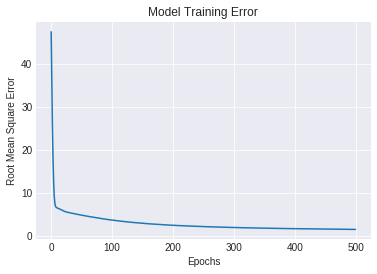

In [35]:

USE_SAVED_MODEL = False

if USE_SAVED_MODEL == False:
    history = model.fit(x_train,
                    y_train,
                    epochs = 500,
                    batch_size = 256,
                    validation_split = 0.2, #data = (x_test, y_test),
                    callbacks = callbacks
                    )
    plt.style.use('seaborn-darkgrid')
    plt.plot(history.history['rmse'])
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Square Error')
    plt.title('Model Training Error')
    plt.show() 
    
else:
    model.load_weights(model_dir+"base_model_weights_1.h5")
                    

In [36]:
lookid_dir = '../input/IdLookupTable.csv'
lookid_data = pd.read_csv(lookid_dir)
test_data = pd.read_csv(test_file)

x_test = []
for i in range(0,len(test_data)):
    img = test_data['Image'][i].split(' ')
    x_test.append(img)
    
x_test = np.array(x_test,dtype = 'float')
x_test = x_test/255.0
x_test = x_test.reshape(-1,96,96,1)    

y_test = model.predict(x_test)
y_test = np.clip(y_test,0,96)

lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pred_list = list(y_test)

rowid = list(lookid_data['RowId'])

feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))
    
    
submit_data = []
for x,y in zip(imageID,feature):
    submit_data.append(pred_list[x][y])
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(submit_data,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)
submission.to_csv('../output/w207_base_submission_1.csv',index = False)    

In [ ]:
if 0:
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
    try:
        del model # this is from global space - change this as you need
    except:
        print("Model clear Failed")
    print(gc.collect())    